In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
import os
import pandas as pd
import numpy as np

EMB_DS = "/kaggle/input/patched-dinov2-embedded"
RW_DS  = "/kaggle/input/camelyon-str-rw-v1"

FEATS_PATH = os.path.join(EMB_DS, "embeddings_dinov2", "features.npy")
INDEX_PATH = os.path.join(EMB_DS, "embeddings_dinov2", "index.csv")
DONE_PATH  = os.path.join(EMB_DS, "embeddings_dinov2", "done.npy")

RW_META  = os.path.join(RW_DS, "str_rw", "rw_meta.csv")
RW_PATHS = os.path.join(RW_DS, "str_rw", "rw_paths.npy")

for p in [FEATS_PATH, INDEX_PATH, DONE_PATH, RW_META, RW_PATHS]:
    print(os.path.exists(p), p)


True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/features.npy
True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/index.csv
True /kaggle/input/patched-dinov2-embedded/embeddings_dinov2/done.npy
True /kaggle/input/camelyon-str-rw-v1/str_rw/rw_meta.csv
True /kaggle/input/camelyon-str-rw-v1/str_rw/rw_paths.npy


In [3]:
rw_meta = pd.read_csv(RW_META)
rw_paths = np.load(RW_PATHS, allow_pickle=True)

assert len(rw_meta) == len(rw_paths), "Mismatch rw_meta vs rw_paths"

# --- AJOUT ICI : filtrage des chemins trop courts ---
MIN_LEN = 40  # essaie 40 d'abord (sinon 30)

mask = (rw_meta["path_len"] >= MIN_LEN).to_numpy()
print("Keeping paths:", mask.sum(), "/", len(mask), "(MIN_LEN =", MIN_LEN, ")")

rw_meta = rw_meta.loc[mask].reset_index(drop=True)
rw_paths = rw_paths[mask]

print("After filter paths per split:")
print(rw_meta.groupby("split")["path_id"].count())
print("New min/mean/max path_len:",
      rw_meta["path_len"].min(),
      rw_meta["path_len"].mean(),
      rw_meta["path_len"].max())


Keeping paths: 1091 / 1120 (MIN_LEN = 40 )
After filter paths per split:
split
test     176
train    758
val      157
Name: path_id, dtype: int64
New min/mean/max path_len: 50 50.0 50


In [4]:
print(rw_meta.groupby(["split","wsi_id"]).size().describe())


count    56.000000
mean     19.482143
std       0.831014
min      16.000000
25%      19.000000
50%      20.000000
75%      20.000000
max      20.000000
dtype: float64


In [5]:
index_df = pd.read_csv(INDEX_PATH)
done = np.load(DONE_PATH)

rw_meta = pd.read_csv(RW_META)
rw_paths = np.load(RW_PATHS, allow_pickle=True)

print("index_df:", index_df.shape, "| done ratio:", done.mean())
print("rw_meta:", rw_meta.shape, "| rw_paths:", len(rw_paths))

assert len(rw_meta) == len(rw_paths), "Mismatch rw_meta vs rw_paths"
assert done.mean() > 0.99, "Embeddings incomplets"

# Embedding dim (ViT base = 768)
EMBED_DIM = 768
feats = np.memmap(FEATS_PATH, dtype=np.float16, mode="r", shape=(len(index_df), EMBED_DIM))

rw_meta.head()

index_df: (16800, 6) | done ratio: 1.0
rw_meta: (1120, 6) | rw_paths: 1120


,split,wsi_id,path_id,path_len,label,start_idx
0,train,normal_074,0,50,0,255
1,train,normal_074,1,50,0,229
2,train,normal_074,2,50,0,120
3,train,normal_074,3,50,0,14
4,train,normal_074,4,50,0,200


In [6]:
tmp = rw_meta.groupby("wsi_id")["label"].nunique().sort_values(ascending=False)
print("Max unique labels per WSI:", tmp.max())
print("WSI with >1 label:", int((tmp > 1).sum()))

# splits
print("\nPaths per split:")
print(rw_meta["split"].value_counts())

print("\nPath length stats:")
print(rw_meta["path_len"].describe())

Max unique labels per WSI: 1
WSI with >1 label: 0

Paths per split:
split
train    780
test     180
val      160
Name: count, dtype: int64

Path length stats:
count    1120.000000
mean       48.731250
std         7.785444
min         1.000000
25%        50.000000
50%        50.000000
75%        50.000000
max        50.000000
Name: path_len, dtype: float64


In [7]:
class STRSequenceDataset(Dataset):
    def __init__(self, rw_meta, rw_paths, feats, split):
        self.meta = rw_meta[rw_meta["split"] == split].reset_index(drop=True)
        self.paths = rw_paths
        self.feats = feats

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, i):
        row = self.meta.iloc[i]
        path_id = int(row["path_id"])
        path = self.paths[path_id]               # liste d'indices vers index_df / feats
        X = np.array(self.feats[path], dtype=np.float32)  # (L, D)

        y = int(row["label"])
        wsi_id = row["wsi_id"]
        return torch.from_numpy(X), torch.tensor(y, dtype=torch.long), wsi_id

def collate_pad(batch):
    Xs, ys, wsi_ids = zip(*batch)
    lengths = torch.tensor([x.shape[0] for x in Xs], dtype=torch.long)
    D = Xs[0].shape[1]
    Lmax = int(max(lengths))

    Xpad = torch.zeros(len(Xs), Lmax, D, dtype=torch.float32)
    for i, x in enumerate(Xs):
        Xpad[i, :x.shape[0]] = x

    y = torch.stack(ys)
    return Xpad, lengths, y, list(wsi_ids)

In [8]:
BATCH_SIZE = 64

train_ds = STRSequenceDataset(rw_meta, rw_paths, feats, "train")
val_ds   = STRSequenceDataset(rw_meta, rw_paths, feats, "val")
test_ds  = STRSequenceDataset(rw_meta, rw_paths, feats, "test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_pad)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_pad)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_pad)

print("Nb sequences:", len(train_ds), len(val_ds), len(test_ds))


Nb sequences: 780 160 180


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, d)

    def forward(self, x):
        L = x.size(1)
        return x + self.pe[:, :L]

class STRTransformer(nn.Module):
    def __init__(self, in_dim=768, d_model=256, nhead=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=512)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.cls = nn.Linear(d_model, 2)

    def forward(self, x, lengths):
        # x: (B, L, D)
        x = self.proj(x)
        x = self.pos(x)

        B, L, _ = x.shape
        pad_mask = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L) >= lengths.unsqueeze(1)

        h = self.enc(x, src_key_padding_mask=pad_mask)  # (B, L, d)

        valid = (~pad_mask).unsqueeze(-1).float()
        pooled = (h * valid).sum(dim=1) / valid.sum(dim=1).clamp_min(1.0)

        logits = self.cls(pooled)
        return logits

model = STRTransformer(in_dim=EMBED_DIM).to(device)
print(model)


STRTransformer(
  (proj): Linear(in_features=768, out_features=256, bias=True)
  (pos): PositionalEncoding()
  (enc): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls): Linear(in_features=256, out_features=2, bias=True)
)


In [10]:
import numpy as np

def agg_topk_mean(values, k=4):
    v = np.asarray(values)
    if len(v) <= k:
        return float(v.mean())
    topk = np.partition(v, -k)[-k:]
    return float(topk.mean())


In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score

criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()

    all_y, all_p, all_wsi = [], [], []
    total_loss = 0.0

    for X, lengths, y, wsi_ids in tqdm(loader, leave=False):
        X = X.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            logits = model(X, lengths)
            loss = criterion(logits, y)

            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

        total_loss += loss.item() * X.size(0)

        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        all_y.extend(y.detach().cpu().numpy().tolist())
        all_p.extend(probs.tolist())
        all_wsi.extend(wsi_ids)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_y, (np.array(all_p) >= 0.5).astype(int))
    auc = roc_auc_score(all_y, all_p) if len(set(all_y)) > 1 else None
    return avg_loss, acc, auc, all_y, all_p, all_wsi


In [12]:
from sklearn.metrics import roc_auc_score

BEST_PATH = "/kaggle/working/best_str_transformer.pt"
EPOCHS = 20
best_val_wsi_auc = -1

patience = 3
bad = 0

history = []

K = 4  # top-k mean (≈20% des ~20 paths/WSI)

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch} =====")

    # ---- TRAIN ----
    tr_loss, tr_acc, tr_auc, _, _, _ = run_epoch(train_loader, train=True)

    # ---- VAL (PATH LEVEL) ----
    va_loss, va_acc, va_auc, yv, pv, wv = run_epoch(val_loader, train=False)

    # ---- VAL (WSI LEVEL, TOP-K MEAN) ----
    df_val = pd.DataFrame({
        "wsi_id": wv,
        "y": yv,
        "p": pv
    })

    wsi_val = df_val.groupby("wsi_id").agg(
        y=("y", "max"),
        p=("p", lambda s: agg_topk_mean(s.values, k=K))
    ).reset_index()

    val_wsi_auc = (
        roc_auc_score(wsi_val["y"], wsi_val["p"])
        if wsi_val["y"].nunique() > 1 else None
    )

    # ---- LOG ----
    history.append((
        epoch,
        tr_loss, tr_acc, tr_auc,
        va_loss, va_acc, va_auc,
        val_wsi_auc
    ))

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.3f} auc {tr_auc} | "
        f"val loss {va_loss:.4f} acc {va_acc:.3f} auc(path) {va_auc} | "
        f"auc(WSI) {val_wsi_auc}"
    )

    # ---- BEST MODEL + EARLY STOPPING (WSI-LEVEL) ----
    if val_wsi_auc is not None and val_wsi_auc > best_val_wsi_auc:
        best_val_wsi_auc = val_wsi_auc
        torch.save(model.state_dict(), BEST_PATH)
        bad = 0
        print("✅ saved best model (VAL WSI-AUC):", best_val_wsi_auc)
    else:
        bad += 1
        if bad >= patience:
            print("⏹️ Early stopping triggered")
            break



===== Epoch 1 =====


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | train loss 0.9145 acc 0.513 auc 0.48511363636363636 | val loss 0.6639 acc 0.625 auc(path) 0.475 | auc(WSI) 0.4
✅ saved best model (VAL WSI-AUC): 0.4

===== Epoch 2 =====


Epoch 02 | train loss 0.6939 acc 0.521 auc 0.5236229946524065 | val loss 0.6827 acc 0.625 auc(path) 0.40149999999999997 | auc(WSI) 0.4

===== Epoch 3 =====


Epoch 03 | train loss 0.6679 acc 0.577 auc 0.613475935828877 | val loss 0.7244 acc 0.412 auc(path) 0.4156666666666667 | auc(WSI) 0.4

===== Epoch 4 =====


Epoch 04 | train loss 0.6460 acc 0.601 auc 0.6534291443850268 | val loss 0.7867 acc 0.388 auc(path) 0.4058333333333333 | auc(WSI) 0.33333333333333337
⏹️ Early stopping triggered


In [13]:
model.load_state_dict(torch.load(BEST_PATH, map_location=device))

te_loss, te_acc, te_auc, y, p, wsi = run_epoch(test_loader, train=False)
print("TEST path-level | loss:", te_loss, "acc:", te_acc, "auc:", te_auc)

df_pred = pd.DataFrame({"wsi_id": wsi, "y": y, "p": p})

# WSI-level: label slide = max des labels (0/1) ; proba = moyenne sur chemins
K = 4
wsi_agg = df_pred.groupby("wsi_id").agg(
    y=("y","max"),
    p=("p", lambda s: agg_topk_mean(s.values, k=K))
).reset_index()


wsi_acc = accuracy_score(wsi_agg["y"], (wsi_agg["p"] >= 0.5).astype(int))
wsi_auc = roc_auc_score(wsi_agg["y"], wsi_agg["p"]) if wsi_agg["y"].nunique() > 1 else None

print("TEST WSI-level  | acc:", wsi_acc, "auc:", wsi_auc)
wsi_agg.head()


TEST path-level | loss: 0.7107328269216749 acc: 0.5555555555555556 auc: 0.30225
TEST WSI-level  | acc: 0.5555555555555556 auc: 0.35000000000000003


,wsi_id,y,p
0,normal_090,0,0.652950
1,normal_111,0,0.615967
2,normal_122,0,0.645862
3,normal_144,0,0.652739
4,tumor_078,1,0.655615


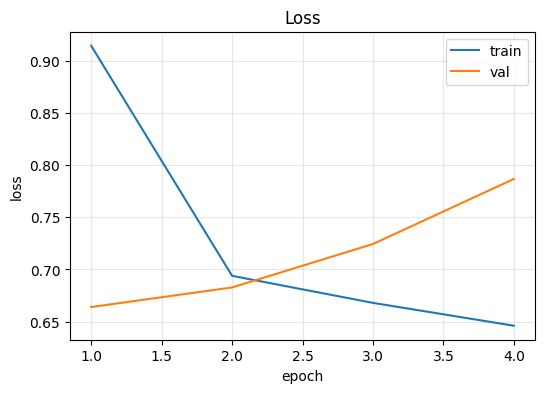

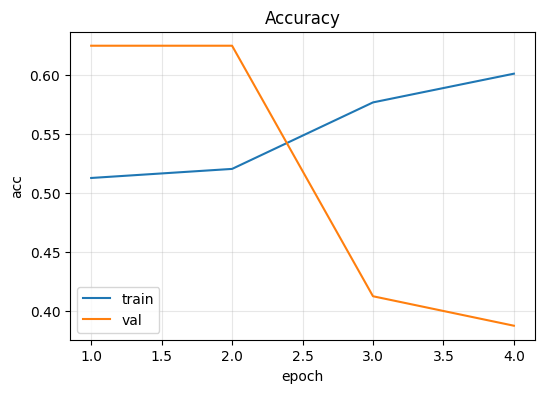

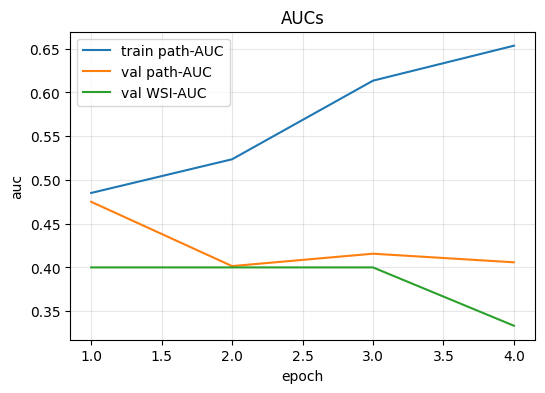

In [14]:
hist = pd.DataFrame(
    history,
    columns=["epoch","tr_loss","tr_acc","tr_auc","va_loss","va_acc","va_auc","val_wsi_auc"]
)


plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["tr_loss"], label="train")
plt.plot(hist["epoch"], hist["va_loss"], label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["tr_acc"], label="train")
plt.plot(hist["epoch"], hist["va_acc"], label="val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.grid(alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["tr_auc"], label="train path-AUC")
plt.plot(hist["epoch"], hist["va_auc"], label="val path-AUC")
plt.plot(hist["epoch"], hist["val_wsi_auc"], label="val WSI-AUC")
plt.title("AUCs"); plt.xlabel("epoch"); plt.ylabel("auc")
plt.grid(alpha=0.3); plt.legend(); plt.show()



In [15]:
RESULTS_CSV = "/kaggle/working/str_results.csv"
wsi_agg.to_csv("/kaggle/working/test_wsi_predictions.csv", index=False)
hist.to_csv("/kaggle/working/train_history.csv", index=False)

print("Saved:", "/kaggle/working/test_wsi_predictions.csv")
print("Saved:", "/kaggle/working/train_history.csv")


Saved: /kaggle/working/test_wsi_predictions.csv
Saved: /kaggle/working/train_history.csv
